# Manifold Learning and ICA

Spencer Scott, Mar 23

## Contents
1. Manifold Learning
2. More Manifold Learning Examples
3. ICA
4. When should I use any of these techniques? 


# 1. Manifold Learning
##  1.1 What is Manifold Learning?

- whereas PCA is a linear dimensionality reduction technique, manifold learning is nonlinear 

    - makes it useful for describing nonlinear features, e.g. emission lines
    
    - using PCA, spectra of emission-line galaxies and quasars can require ~30 components (Ivezic et al 2014)
    
    - using manifold learning, the same spectra can require as few as 2 components (Vanderplas and Connolly 2009)
    
- manifold learning refers to a broad set of techniques

- later we will discuss two: locally linear embedding (LLE), and isometric mapping (IsoMap).

## 1.2 Why use Manifold Learning? 

- high dimensional data with very nonlinear features 
    
    - good for classification, visualization, same things (mostly) as linear dimensionality reduction techniques, but for data with nonlinear features
   

- a common example, on the next slide, is the "S curve"
    
    - linear dimensionality reduction (PCA) does not do a good job of preserving local structure in data



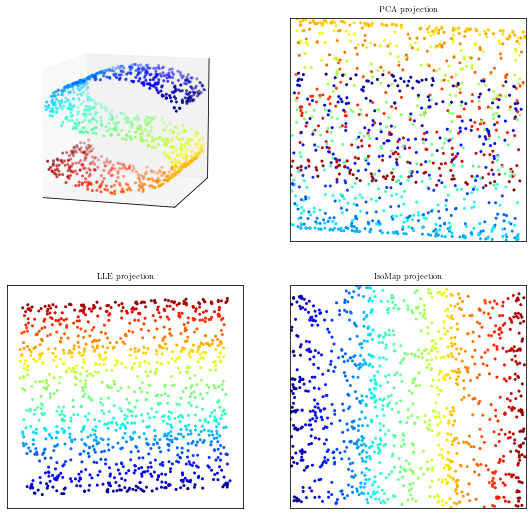

In [4]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

from sklearn import manifold, datasets, decomposition

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# generate the S-curve dataset
np.random.seed(0)

n_points = 1100
n_neighbors = 10
out_dim = 2

X, color = datasets.make_s_curve(n_points)

# change the proportions to emphasize the weakness of PCA
X[:, 1] -= 1
X[:, 1] *= 1.5
X[:, 2] *= 0.5

#------------------------------------------------------------
# Compute the projections
pca = decomposition.PCA(out_dim)
Y_pca = pca.fit_transform(X)

lle = manifold.LocallyLinearEmbedding(n_neighbors, out_dim, method='modified',
                                      random_state=0, eigen_solver='dense')
Y_lle = lle.fit_transform(X)

iso = manifold.Isomap(n_neighbors, out_dim)
Y_iso = iso.fit_transform(X)

#------------------------------------------------------------
# plot the 3D dataset
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)
try:
    # matplotlib 1.0+ has a toolkit for generating 3D plots
    from mpl_toolkits.mplot3d import Axes3D
    ax1 = fig.add_subplot(221, projection='3d',
                          xticks=[], yticks=[], zticks=[])
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color,
                cmap=plt.cm.jet, s=9, lw=0)
    ax1.view_init(11, -73)

except:
    # In older versions, we'll have to wing it with a 2D plot
    ax1 = fig.add_subplot(221)

    # Create a projection to mimic 3D scatter-plot
    X_proj = X / (X.max(0) - X.min(0))
    X_proj -= X_proj.mean(0)
    R = np.array([[0.5, 0.0],
                  [0.1, 0.1],
                  [0.0, 0.5]])
    R /= np.sqrt(np.sum(R ** 2, 0))
    X_proj = np.dot(X_proj, R)

    # change line width with depth
    lw = X[:, 1].copy()
    lw -= lw.min()
    lw /= lw.max()
    lw = 1 - lw

    ax1.scatter(X_proj[:, 0], X_proj[:, 1], c=color,
                cmap=plt.cm.jet, s=9, lw=lw, zorder=10)

    # draw the shaded axes
    ax1.fill([-0.7, -0.3, -0.3, -0.7, -0.7],
             [-0.7, -0.3, 0.7, 0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.3, 0.7, 0.7, -0.3, -0.3],
             [-0.3, -0.3, 0.7, 0.7, -0.3], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.7, 0.3, 0.7, -0.3, -0.7],
             [-0.7, -0.7, -0.3, -0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)

    ax1.xaxis.set_major_locator(ticker.NullLocator())
    ax1.yaxis.set_major_locator(ticker.NullLocator())

#------------------------------------------------------------
# Plot the projections
subplots = [222, 223, 224]
titles = ['PCA projection', 'LLE projection', 'IsoMap projection']
Yvals = [Y_pca, Y_lle, Y_iso]

for (Y, title, subplot) in zip(Yvals, titles, subplots):
    ax = fig.add_subplot(subplot)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Things to note: 
- the first two principle components mix up the color information
    - thinking about how PCA works, this makes sense
    - The variance along each axis is very similar
- different manifold learning techniques result in different embeddings
    - more on this later


## 1.3 Locally Linear Embedding (LLE) 
- aims to preserve the local geometry around each point
    - neighborhood around each point is determined by its *k* nearest neighbors
- LLE has two main steps:
    1. determine weights that can reconstruct a point from its *k* nearest neighbors
    2. find a new, lower dimensional data set that preserves the relationships defined by the weights

### Step one: 
Define a matrix *X* as an *N* $\times$ *K* matrix that represents *N* points in *K* dimensions 

Find the matrix *W* which minimizes reconstruction error defined as follows: 

$E_1(W) = | X - WX |^2$

What does this do, though? "This is, essentially, finding the hyperplane that best describes the local surface at each point within the dataset" (Ivezic et al. 2014)

### However, this on its own is not enough! 

- One of the essential ideas of LLE is that *W* must describe only the local neighborhood of each point
- In order to do this, set all $W_{ij} = 0 $ unless *j* is one of the nearest neighbors of *i*

### Step two:
"Second verse, same as the first!"

Find the matrix *Y* which minimizes the quantity: 

$E_1(W) = | Y - WY |^2$

Where *Y* is an *N* $\times$ *d* matrix such that $ d < K $ and *W* is kept fixed

## 1.4 IsoMap

- based on a multidimensional scaling (MDS) framework

- again given an *N* $\times$ *K* matrix *X*, one can calculate a distance matrix *D* such that *D_{ij}* is the distance from point *i* to point *j*
    - in broad terms, MDS inverts this process by taking *D* and finding a matrix *Y* which minimizes reconstruction error
    - for more details on the math here, see the book

- IsoMap uses MDS along with a stand-in for the real distance matrix *D*

### What's the stand-in matrix? 
- represent the data with a connected graph *G*
    - $G_{ij}$ is the distance between *i* and *j* if *i* and *j* are neighbors, 0 otherwise (similar to LLE)
- *D* is then defined such that $D_{ij}$ is the length of the shortest path from *i* to *j* on *G*

# 2.  More Manifold Learning Examples

Automatically created module for IPython interactive environment
LLE: 0.34 sec
LTSA: 0.64 sec
Hessian LLE: 0.73 sec
Modified LLE: 0.53 sec
Isomap: 0.72 sec
MDS: 3.2 sec
SE: 0.24 sec
t-SNE: 11 sec


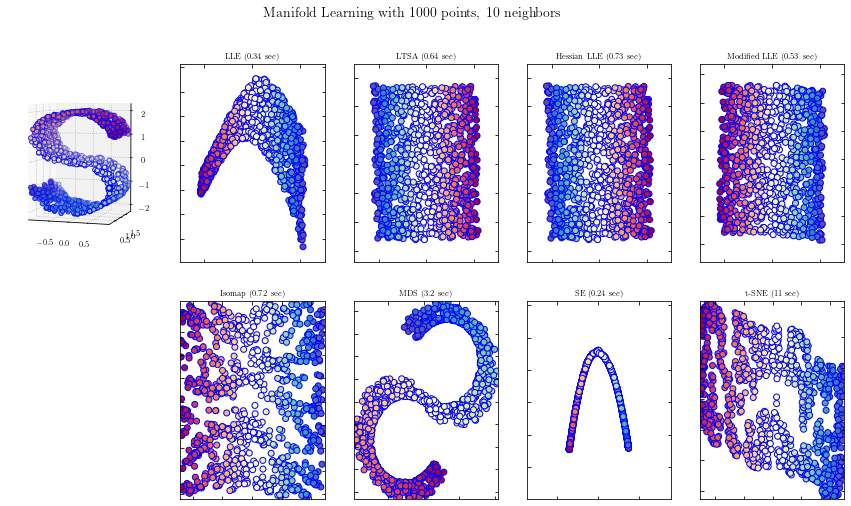

In [5]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

Automatically created module for IPython interactive environment
standard: 0.12 sec
ltsa: 0.22 sec
hessian: 0.38 sec
modified: 0.3 sec
ISO: 0.27 sec
MDS: 1.6 sec
Spectral Embedding: 0.11 sec
t-SNE: 6.5 sec


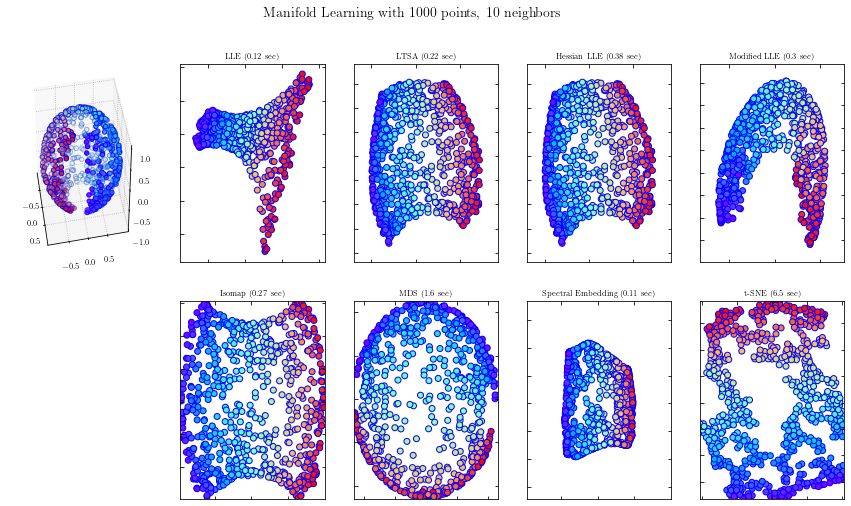

In [6]:
# Author: Jaques Grobler <jaques.grobler@inria.fr>
# License: BSD 3 clause

print(__doc__)

from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

# Next line to silence pyflakes.
Axes3D

# Variables for manifold learning.
n_neighbors = 10
n_samples = 1000

# Create our sphere.
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# Perform Locally Linear Embedding Manifold learning
methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    trans_data = manifold\
        .LocallyLinearEmbedding(n_neighbors, 2,
                                method=method).fit_transform(sphere_data).T
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

# Perform Isomap Manifold learning.
t0 = time()
trans_data = manifold.Isomap(n_neighbors, n_components=2)\
    .fit_transform(sphere_data).T
t1 = time()
print("%s: %.2g sec" % ('ISO', t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ('Isomap', t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1)
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2,
                                n_neighbors=n_neighbors)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

# 3. Independent Component Analysis
## 3.1 What is Independent Component Analysis? 
- technique to solve the "cocktail party problem" 
    - in a room of *N* people, there are *N* microphones
    - each one picks up a linear combination of *N* voices
    - want to unmix the voices to define the sources
- ICA uses the concept of statistical independence to do so

## 3.2 Explaining ICA with an Example
- in an astronomical example, each galaxy spectrum is the microphone picking up the input signals from stars and HII regions
- each spectrum $x_i(k)$ can be written as:

$x_i(k) = a_{i1}s_1(k) + a_{i2}s_2(k) + ... $

Where $s_i(k)$ are the spectra of each individual star and $a_{ij}$ are the mixing amplitudes

Write this now as 

$X = AS$

Then extracting the signal spectra is just estimating the weight matrix $W$ such that 

$S = WX$

- Key insight: each input signal should be statistically independent

- What does this mean for using ICA, though? 
    - the sum of two random variables is more Gaussian than either one independently
    - therefore, we can define statistical independence of random variables in terms of non-Gaussianity
    - find the unmixing matrix $W$ that maximizes non-Gaussianity
- once this matrix is known, can reduce dimensionality by focusing on "loudest" microphones with largest values $a_{ij}$


# 4. When should I use any of these techniques? 
## 4.1 Pitfalls of manifold learning
- not good for noisy or gappy data
- sensitive to outliers
- results are dependent on the choice of tuning parameters
    - no accepted way of choosing the optimal set of parameters
- no easy way to know the dimensionality of the data
    - when using PCA, this can be estimated from the eigenvalues of the eigenbasis
- cannot be used for compression of data due to dependence on *k* nearest neighbors

## Which technique should I use? 
The book has an extended discussion on each one of these points, but the general overview is this

- I care most about accuracy: 
    - PCA and LLE are good choices, ICA does not perform as well here 
    - between PCA and LLE, consider linearity of data, among other factors
- I care most about interpreting my data
    - of the options discussed, PCA is the best choice, as it gives a direction and relative importance of each axis
    - manifold learning such as LLE or IsoMap just give positions of points in lower-dimensional space 
- I care most about code runtime (scalability)
    - PCA is simple and fast
    - in general, nonlinear dimensionality reduction techniques are slower
        - dependence on *k* nearest neighbors which is $O(N^2$

The book has a good table in summary of these points: 
![alt](lecture11_files/comparison_table.png)

References: 
Željko Ivezic, Andrew J. Connolly, Jacob T. VanderPlas, and Alexander Gray (2014). Statistics, Data Mining, and Machine Learning in Astronomy. Princeton Series in Modern Observational Astronomy

Vanderplas, J. and A. Connolly (2009). Reducing the dimensionality of data: Locally linear embedding of Sloan Galaxy Spectra. AJ 138, 1365–1379.
